In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import os 
import cv2
import gc
import random 
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import binary_crossentropy as BCE
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
BATCH_SIZE = 84
epochs = 20
n_splits = 5
fold_selected = 1
img_size = (224, 224, 3)
seed = 42
AUTOTUNE = tf.data.AUTOTUNE

df = pd.read_csv("../input/uw-madison-gi-tract-image-segmentation/train.csv")
df.head(5)

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [3]:
df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
df["slice"] = df["id"].apply(lambda x: x.split("_")[3])

Train_dir = "../input/uw-madison-gi-tract-image-segmentation/train"
all_train_images = glob(os.path.join(Train_dir, "**", "*.png"), recursive = True)
x = all_train_images[0].rsplit('/', 4)[0]

path_partial_list = []
for i in range(0, df.shape[0]):
    path_partial_list.append(os.path.join(x, 
                                          "case"+str(df["case"].values[i]),
                                          "case"+str(df["case"].values[i])
                                         +"_"+"day"+str(df["day"].values[i]),
                                         "scans",
                                         "slice_"+str(df["slice"].values[i])))

df["path_partial"] = path_partial_list

path_partial_list = []
for i in range(0, len(all_train_images)):
    path_partial_list.append(str(all_train_images[i].rsplit("_", 4)[0]))
    
tmp_df = pd.DataFrame()
tmp_df['path_partial'] = path_partial_list
tmp_df['path'] = all_train_images

df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
df["px_spacing_h"] = df["path"].apply(lambda x: float(x[:-4].rsplit("_",4)[3]))
df["px_spacing_w"] = df["path"].apply(lambda x: float(x[:-4].rsplit("_",4)[4]))

del x, path_partial_list, tmp_df
gc.collect()
df.head(5)

,id,class,segmentation,case,day,slice,path,width,height,px_spacing_h,px_spacing_w
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,1.5
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,1.5
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,1.5
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,1.5
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5,1.5


In [4]:
# Restructure dataframe 
df_train = pd.DataFrame({'id':df['id'][::3]})
df_train['large_bowel'] = df['segmentation'][::3].values
df_train['small_bowel'] = df['segmentation'][1::3].values
df_train['stomach'] = df['segmentation'][2::3].values
df_train['path'] = df['path'][::3].values
df_train['case'] = df['case'][::3].values
df_train['day'] = df['day'][::3].values
df_train['slice'] = df['slice'][::3].values
df_train['width'] = df['width'][::3].values
df_train['height'] = df['height'][::3].values

df_train.reset_index(inplace=True, drop=True)
df_train.fillna('', inplace=True)
df_train['count'] = np.sum(df_train.iloc[:,1:4] != '', axis = 1).values
df_train.sample(5)

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
3120,case88_day38_slice_0097,18952 7 19307 15 19664 19 20021 23 20054 5 203...,,31518 10 31874 15 32232 20 32591 24 32949 27 3...,../input/uw-madison-gi-tract-image-segmentatio...,88,38,0097,360,310,2
25193,case43_day26_slice_0058,,,40346 2 40609 6 40873 9 41138 11 41402 13 4166...,../input/uw-madison-gi-tract-image-segmentatio...,43,26,0058,266,266,1
10690,case140_day0_slice_0067,,,19850 10 20111 16 20376 18 20641 20 20907 20 2...,../input/uw-madison-gi-tract-image-segmentatio...,140,0,0067,266,266,1
38171,case74_day18_slice_0108,22252 8 22517 16 22782 20 22805 9 23048 33 233...,,22756 4 23011 17 23275 20 23539 22 23803 24 24...,../input/uw-madison-gi-tract-image-segmentatio...,74,18,0108,266,266,2
20622,case149_day12_slice_0063,,,25406 12 25670 16 25936 17 26201 19 26467 20 2...,../input/uw-madison-gi-tract-image-segmentatio...,149,12,0063,266,266,1


In [5]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False,
                 img_shape = img_size , aug_dat=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.aug_dat = aug_dat
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size,self.img_shape[0],self.img_shape[1],self.img_shape[2]))
        y = np.empty((self.batch_size,self.img_shape[0],self.img_shape[1],self.img_shape[2]))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        id_, heights, widths, classes = [], [], [], [] 
        
        for i, img_path in enumerate(self.df['path'].iloc[indexes]):
            if self.subset != 'train':
                id_.append(self.df['id'].iloc[indexes[i]])
                heights.append(self.df['height'].iloc[indexes[i]])
                widths.append(self.df['width'].iloc[indexes[i]])
                classes.append(self.df['class'].iloc[indexes[i]])
            
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            
            img = self.__load_grayscale(img_path)  
            X[i,] = np.concatenate((img, img, img), axis = -1)
            
            if self.subset == 'train':
                for k,j in enumerate(["large_bowel","small_bowel","stomach"]):
                    rles = self.df[j].iloc[indexes[i]]
                    mask = rle_decode(rles, shape=(h, w, 1))
                    mask = cv2.resize(mask, self.img_shape[0:2])
                    y[i,:,:,k] = mask
            
            if self.aug_dat:
                lb = self.df['large_bowel'].iloc[indexes[i]]
                sb = self.df['small_bowel'].iloc[indexes[i]]
                st = self.df['stomach'].iloc[indexes[i]]
                if lb != '' and sb != '' and st != '':
                    imag_, mask_ = self.__aug_img(X[i,], y[i,])
                    X = np.concatenate((X, imag_), axis = 0)
                    y = np.concatenate((y, mask_), axis = 0)

        if self.subset == 'train':
            return tf.convert_to_tensor(X, dtype=tf.float32), tf.convert_to_tensor(y, dtype=tf.float32)
        else: 
            return X, id_, widths, heights, classes

        
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = self.img_shape[0:2]
        img = cv2.resize(img, dsize)
        img = img.astype('float32') # original is uint16
        img = (img - img.min())/(img.max() - img.min())*255.0 # scale image to [0, 255]
        img = img.astype('uint8')/255
        img = np.expand_dims(img, axis=-1)
        return img
    
    def __aug_img(self, img, mask):
        im = np.empty((1,self.img_shape[0],self.img_shape[1],self.img_shape[2]))
        mk = np.empty((1,self.img_shape[0],self.img_shape[1],self.img_shape[2])) 
        img_ = img
        mask_ = mask 
        while len(np.unique(img - img_)) == 1: 
            Nb_random = np.random.randint(low = 0, high=100, size=2)
            seed = (Nb_random[0],Nb_random[1])
            if seed[0]/100 < 0.3: 
                img_ = tf.image.stateless_random_flip_up_down(img_, seed=seed)
                mask_ = tf.image.stateless_random_flip_up_down(mask_, seed=seed)
            elif seed[0]/100 > 0.7: 
                img_ = tf.image.stateless_random_flip_left_right(img_, seed=seed)
                mask_ = tf.image.stateless_random_flip_left_right(mask_, seed=seed)
            else: 
                img_ = tf.image.stateless_random_flip_left_right(img_, seed=seed)
                mask_ =  tf.image.stateless_random_flip_left_right(mask_, seed=seed)
                img_ = tf.image.stateless_random_flip_up_down(img_, seed=seed)
                mask_ = tf.image.stateless_random_flip_up_down(mask_, seed=seed)
        im[0,] = img_
        mk[0,] = mask_
        return im, mk  

In [7]:
# train_mask = list(df_train[(df_train['large_bowel'] == '') & 
#                            (df_train['small_bowel'] == '') &
#                            (df_train['stomach'] == '')].index)
# train_mask = random.sample(train_mask, int(0.5*float(len(train_mask))))
# df_train = df_train[~df_train.index.isin(train_mask)]

In [8]:
# train_mask = list(df_train[df_train['large_bowel'] != ''].index)
# train_mask += list(df_train[df_train['small_bowel'] != ''].index)
# train_mask += list(df_train[df_train['stomach'] != ''].index)

# df_train = df_train[df_train.index.isin(train_mask)]
# df_train.reset_index(inplace=True, drop=True)
remove_ids = ["case7_day0", "case81_day30"]
for _id in remove_ids:
    df_train = df_train[~df_train.id.str.contains(_id)].reset_index(drop=True)

In [9]:
# Cross validation
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=df_train, y=df_train['count'], 
                                              groups=df_train['case']), 1):
    df_train.loc[val_idx, 'fold'] = fold

train_ids = df_train[df_train["fold"]!=fold_selected].index
valid_ids = df_train[df_train["fold"]==fold_selected].index

df_train.groupby('fold').size()

fold
1.0    8496
2.0    7136
3.0    7392
4.0    8128
5.0    7056
dtype: int64

In [10]:
train_generator = DataGenerator(df_train[df_train.index.isin(train_ids)],shuffle=True,aug_dat=True)
val_generator = DataGenerator(df_train[df_train.index.isin(valid_ids)],batch_size=BATCH_SIZE*2,aug_dat=True)

In [11]:
def dice_coef(y_true,y_pred):
    y_true_f=tf.reshape(tf.dtypes.cast(y_true, tf.float32),[-1])
    y_pred_f=tf.reshape(tf.dtypes.cast(y_pred, tf.float32),[-1])
    intersection=tf.reduce_sum(y_true_f*y_pred_f)
    sum_ = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return (2. * intersection + 1.) / (sum_ + 1.)


def iou_coef(y_true, y_pred):   
    y_true_f=tf.reshape(tf.dtypes.cast(y_true, tf.float32),[-1])
    y_pred_f=tf.reshape(tf.dtypes.cast(y_pred, tf.float32),[-1])
    intersection=tf.reduce_sum(y_true_f*y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    iou = (intersection+1.) / (union+1.)
    return iou


def bce_dice_loss(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    return 0.5*BCE(y_true, y_pred) + 0.5*(1-dice_coef(y_true, y_pred))

In [12]:
# Unet
def conv_block(inputs, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, 
                  3, 
                  activation='relu', 
                  padding='same', 
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  3, 
                  activation='relu', 
                  padding='same', 
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)    
    conv = BatchNormalization()(conv)
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
    else:
        next_layer = conv
    skip_connection = conv
    return next_layer, skip_connection


def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(n_filters, 
                         3, 
                         strides=(2,2), 
                         padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, 
                  3, 
                  activation='relu', 
                  padding='same', 
                  kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters, 
                  3, 
                  activation='relu', 
                  padding='same', 
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    return conv


def unet_model(input_size, n_filters=32, n_classes=3):
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob = 0.3)
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob = 0.3, max_pooling = False) 
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)
    conv9 = Conv2D(n_filters, 
                   3, 
                   activation='relu', 
                   padding='same', 
                   kernel_initializer=tf.keras.initializers.HeNormal())(ublock9)
    conv10 = Conv2D(n_classes, 
                    1, 
                    activation='sigmoid', 
                    padding='same')(conv9)
    model = Model(inputs=inputs, outputs=conv10)
    return model

In [13]:
unet = unet_model(img_size)
unet.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=bce_dice_loss, 
             metrics=[dice_coef, iou_coef])
unet.summary()

2022-06-14 12:47:14.517088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 12:47:14.617049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 12:47:14.618300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 12:47:14.620845: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [14]:
es = EarlyStopping(monitor='val_loss', patience=5)
lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2)
# Train the model
history = unet.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[es, lr],
    epochs=epochs
)

2022-06-14 12:47:19.131972: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-06-14 12:47:23.632757: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  3/353 [..............................] - ETA: 46:40 - loss: 0.8892 - dice_coef: 0.0149 - iou_coef: 0.0075

2022-06-14 12:47:58.529356: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 12/353 [>.............................] - ETA: 24:24 - loss: 0.6773 - dice_coef: 0.0225 - iou_coef: 0.0115

2022-06-14 12:48:32.017072: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 48/353 [===>..........................] - ETA: 16:39 - loss: 0.5025 - dice_coef: 0.1140 - iou_coef: 0.0617

2022-06-14 12:50:18.766791: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 54/353 [===>..........................] - ETA: 16:28 - loss: 0.4911 - dice_coef: 0.1268 - iou_coef: 0.0692

2022-06-14 12:50:40.143897: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 64/353 [====>.........................] - ETA: 15:52 - loss: 0.4755 - dice_coef: 0.1469 - iou_coef: 0.0814

2022-06-14 12:51:10.999307: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


138/353 [==========>...................] - ETA: 10:33 - loss: 0.4001 - dice_coef: 0.2673 - iou_coef: 0.1605

2022-06-14 12:54:30.056742: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


172/353 [=============>................] - ETA: 8:54 - loss: 0.3775 - dice_coef: 0.3059 - iou_coef: 0.1884

2022-06-14 12:56:11.533451: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


353/353 [==============================] - 1387s 4s/step - loss: 0.3034 - dice_coef: 0.4377 - iou_coef: 0.2939 - val_loss: 0.5256 - val_dice_coef: 0.0358 - val_iou_coef: 0.0187
Epoch 2/20
353/353 [==============================] - 909s 3s/step - loss: 0.1588 - dice_coef: 0.7028 - iou_coef: 0.5432 - val_loss: 0.2219 - val_dice_coef: 0.5826 - val_iou_coef: 0.4171
Epoch 3/20
353/353 [==============================] - 907s 3s/step - loss: 0.1289 - dice_coef: 0.7589 - iou_coef: 0.6123 - val_loss: 0.2012 - val_dice_coef: 0.6208 - val_iou_coef: 0.4599
Epoch 4/20
353/353 [==============================] - 905s 3s/step - loss: 0.1123 - dice_coef: 0.7898 - iou_coef: 0.6534 - val_loss: 0.1626 - val_dice_coef: 0.6956 - val_iou_coef: 0.5374
Epoch 5/20
353/353 [==============================] - 902s 3s/step - loss: 0.1031 - dice_coef: 0.8069 - iou_coef: 0.6769 - val_loss: 0.1648 - val_dice_coef: 0.6920 - val_iou_coef: 0.5348
Epoch 6/20
353/353 [==============================] - 904s 3s/step - loss: 

2022-06-14 15:48:04.191643: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


353/353 [==============================] - 916s 3s/step - loss: 0.0641 - dice_coef: 0.8797 - iou_coef: 0.7855 - val_loss: 0.1304 - val_dice_coef: 0.7571 - val_iou_coef: 0.6140
Epoch 13/20
353/353 [==============================] - 901s 3s/step - loss: 0.0622 - dice_coef: 0.8832 - iou_coef: 0.7910 - val_loss: 0.1337 - val_dice_coef: 0.7504 - val_iou_coef: 0.6066
Epoch 14/20
353/353 [==============================] - 902s 3s/step - loss: 0.0609 - dice_coef: 0.8856 - iou_coef: 0.7949 - val_loss: 0.1345 - val_dice_coef: 0.7497 - val_iou_coef: 0.6064
Epoch 15/20
353/353 [==============================] - 907s 3s/step - loss: 0.0593 - dice_coef: 0.8885 - iou_coef: 0.7996 - val_loss: 0.1317 - val_dice_coef: 0.7547 - val_iou_coef: 0.6116
Epoch 16/20
353/353 [==============================] - 906s 3s/step - loss: 0.0590 - dice_coef: 0.8891 - iou_coef: 0.8005 - val_loss: 0.1316 - val_dice_coef: 0.7550 - val_iou_coef: 0.6121
Epoch 17/20
353/353 [==============================] - 911s 3s/step - lo

In [15]:
unet.save('/kaggle/working/Unet.h5') 
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('/kaggle/working/history.csv')

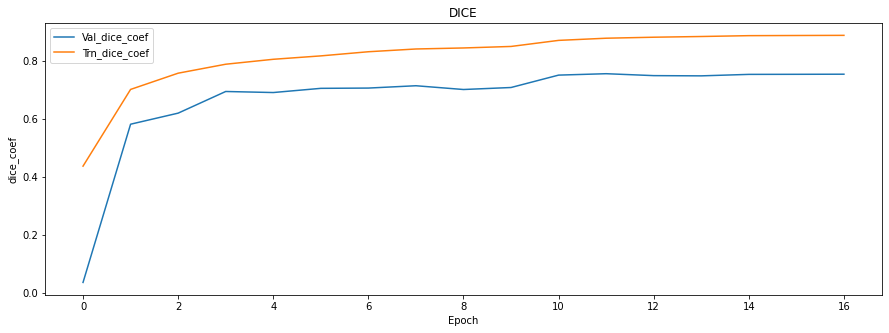

In [16]:
# Plot training and validation results
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Trn_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 
plt.show()

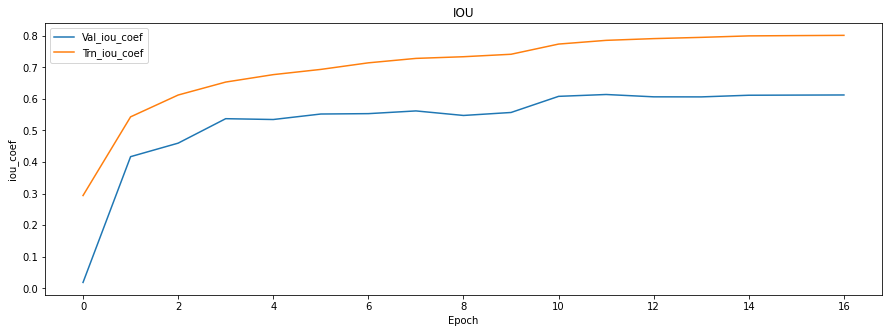

In [17]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_iou_coef'],label='Val_iou_coef')
plt.plot(range(history.epoch[-1]+1),history.history['iou_coef'],label='Trn_iou_coef')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend(); 
plt.show()

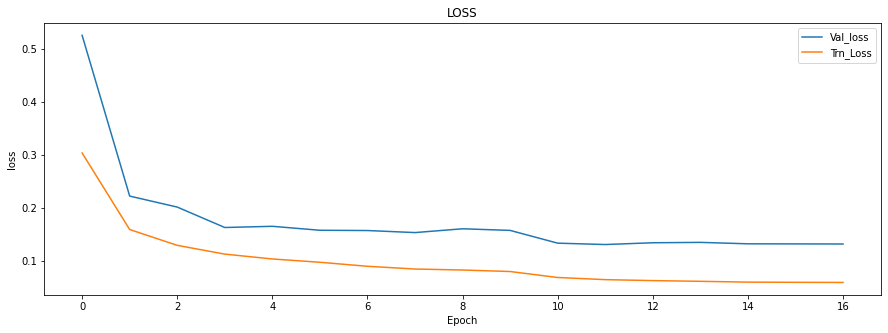

In [18]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='Trn_Loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend(); 
plt.show()

In [19]:
# Prediction 
custom_objects = {'dice_coef': dice_coef, 'iou_coef': iou_coef, 
                  'bce_dice_loss': bce_dice_loss}
model = load_model("/kaggle/working/Unet.h5", custom_objects=custom_objects)

In [20]:
pred_batches = DataGenerator(df_train[df_train.index.isin(valid_ids[0:8])], batch_size=1, shuffle=False)
preds = model.predict(pred_batches, verbose=1)

8/8 [==============================] - 1s 8ms/step


In [21]:
pred_batches[0][0].shape

TensorShape([1, 224, 224, 3])

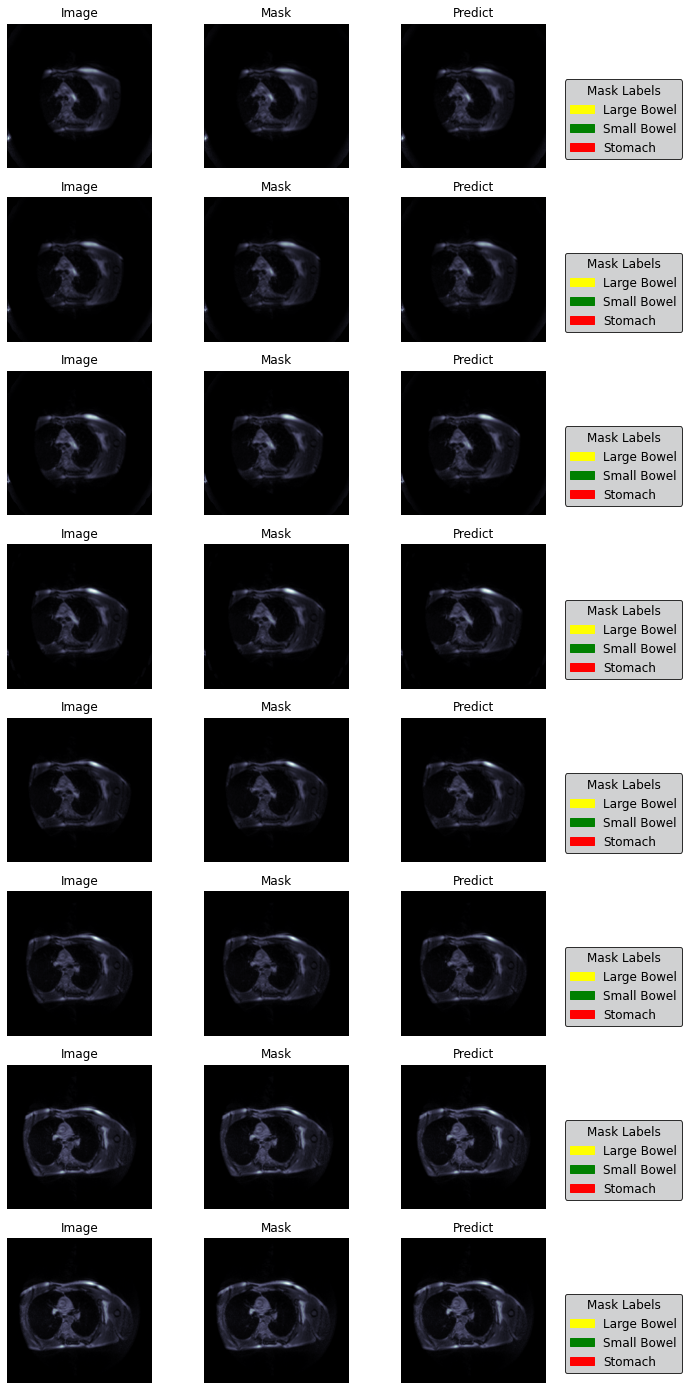

In [22]:
Threshold = 0.1
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=8, ncols=3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(8):
    images, mask = pred_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    pre=preds[i]
    predict1=pre[:,:,0]
    predict2=pre[:,:,1]
    predict3=pre[:,:,2]
    
    predict1 = (predict1 > Threshold).astype(np.float32)
    predict2 = (predict2 > Threshold).astype(np.float32)
    predict3 = (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    #--------------------------
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12,  y=1.01)
    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1==False, mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2==False, mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3==False, mask3),cmap=cmap3, alpha=1)
    #--------------------------
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Predict", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap='bone')
    l1 = ax2.imshow(np.ma.masked_where(predict1==False, predict1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2==False, predict2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3==False, predict3),cmap=cmap3, alpha=1)
   

    _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4, fontsize = 12, title='Mask Labels', title_fontsize=12, edgecolor="black",  facecolor='#c5c6c7')